# How to use the graph API

This guide demonstrates the basics of LangGraph's Graph API. It walks through [state](#define-and-update-state), as well as composing common graph structures such as [sequences](#create-a-sequence-of-steps), [branches](#create-branches-for-parallel-node-execution), and [loops](#visualize-your-graph).

## Setup

Install `langgraph`:

In [ ]:
%pip install -qU langgraph

<div class="admonition tip">
     <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for better debugging</p>
     <p style="padding-top: 5px;">
         Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM aps built with LangGraph — read more about how to get started in the <a href="https://docs.smith.langchain.com">docs</a>. 
     </p>
 </div>

## Define and update state

Here we show how to define and update [state](../../concepts/low_level/#state) in LangGraph. We will demonstrate:

1. How to use state to define a graph's [schema](../../concepts/low_level/#schema)
2. How to use [reducers](../../concepts/low_level/#reducers) to control how state updates are processed.

We will use [messages](../../concepts/low_level/#messagesstate) in our examples. This represents a versatile formulation of state for many LLM applications. See our [concepts page](../../concepts/low_level/#working-with-messages-in-graph-state) for more detail.

### Example graph

#### Define state
[State](../../concepts/low_level/#state) in LangGraph can be a `TypedDict`, `Pydantic` model, or dataclass. Below we will use `TypedDict`. See [this guide](../../how-tos/state-model) for detail on using Pydantic.

By default, graphs will have the same input and output schema, and the state determines that schema. See [this guide](../../how-tos/input_output_schema/) for how to define distinct input and output schemas.

Let's consider a simple example:

In [1]:
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict


class State(TypedDict):
    messages: list[AnyMessage]
    extra_field: int

This state tracks a list of [message](https://python.langchain.com/docs/concepts/messages/) objects, as well as an extra integer field.

#### Define graph structure

Let's build an example graph with a single node. Our [node](../../concepts/low_level/#nodes) is just a Python function that reads our graph's state and makes updates to it. The first argument to this function will always be the state:

In [2]:
from langchain_core.messages import AIMessage


def node(state: State):
    messages = state["messages"]
    new_message = AIMessage("Hello!")

    return {"messages": messages + [new_message], "extra_field": 10}

This node simply appends a message to our message list, and populates an extra field.

!!! important

    Nodes should return updates to the state directly, instead of mutating the state.

Let's next define a simple graph containing this node. We use [StateGraph](../../concepts/low_level/#stategraph) to define a graph that operates on this state. We then use [add_node](../../concepts/low_level/#messagesstate) populate our graph.

In [3]:
from langgraph.graph import StateGraph

builder = StateGraph(State)
builder.add_node(node)
builder.set_entry_point("node")
graph = builder.compile()

LangGraph provides built-in utilities for visualizing your graph. Let's inspect our graph. See [this guide](../../how-tos/visualization) for detail on visualization.

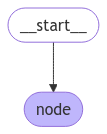

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In this case, our graph just executes a single node.

#### Use graph

Let's proceed with a simple invocation:

In [5]:
from langchain_core.messages import HumanMessage

result = graph.invoke({"messages": [HumanMessage("Hi")]})
result

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Hello!', additional_kwargs={}, response_metadata={})],
 'extra_field': 10}

Note that:

- We kicked off invocation by updating a single key of the state.
- We receive the entire state in the invocation result.

For convenience, we frequently inspect the content of [message objects](https://python.langchain.com/docs/concepts/messages/) via pretty-print:

In [6]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


### Process state updates with reducers

Each key in the state can have its own independent [reducer](../../concepts/low_level/#reducers) function, which controls how updates from nodes are applied. If no reducer function is explicitly specified then it is assumed that all updates to the key should override it.

For `TypedDict` state schemas, we can define reducers by annotating the corresponding field of the state with a reducer function.

In the earlier example, our node updated the `"messages"` key in the state by appending a message to it. Below, we add a reducer to this key, such that updates are automatically appended:

In [7]:
from typing_extensions import Annotated


def add(left, right):
    """Can also import `add` from the `operator` built-in."""
    return left + right


class State(TypedDict):
    # highlight-next-line
    messages: Annotated[list[AnyMessage], add]
    extra_field: int

Now our node can be simplified:

In [8]:
def node(state: State):
    new_message = AIMessage("Hello!")
    # highlight-next-line
    return {"messages": [new_message], "extra_field": 10}

In [10]:
from langgraph.graph import START


graph = StateGraph(State).add_node(node).add_edge(START, "node").compile()

result = graph.invoke({"messages": [HumanMessage("Hi")]})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


#### MessagesState

In practice, there are additional considerations for updating lists of messages:

- We may wish to update an existing message in the state.
- We may want to accept short-hands for [message formats](../../concepts/low_level/#using-messages-in-your-graph), such as [OpenAI format](https://python.langchain.com/docs/concepts/messages/#openai-format).

LangGraph includes a built-in reducer `add_messages` that handles these considerations:

In [11]:
from langgraph.graph.message import add_messages


class State(TypedDict):
    # highlight-next-line
    messages: Annotated[list[AnyMessage], add_messages]
    extra_field: int


def node(state: State):
    new_message = AIMessage("Hello!")
    return {"messages": [new_message], "extra_field": 10}


graph = StateGraph(State).add_node(node).set_entry_point("node").compile()

In [12]:
# highlight-next-line
input_message = {"role": "user", "content": "Hi"}

result = graph.invoke({"messages": [input_message]})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


This is a versatile representation of state for applications involving [chat models](https://python.langchain.com/docs/concepts/chat_models/). LangGraph includes a pre-built `MessagesState` for convenience, so that we can have:

In [13]:
from langgraph.graph import MessagesState


class State(MessagesState):
    extra_field: int

## Create a sequence of steps

!!! info "Prerequisites"
    This guide assumes familiarity with the above section on [state](#define-and-update-state).

Here we demonstrate how to construct a simple sequence of steps. We will show:

1. How to build a sequential graph
2. Built-in short-hand for constructing similar graphs.


### Summary

To add a sequence of nodes, we use the `.add_node` and `.add_edge` methods of our [graph](../../concepts/low_level/#stategraph):
```python
from langgraph.graph import START, StateGraph

builder = StateGraph(State)

# Add nodes
builder.add_node(step_1)
builder.add_node(step_2)
builder.add_node(step_3)

# Add edges
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
```

We can also use the built-in shorthand `.add_sequence`:
```python
builder = StateGraph(State).add_sequence([step_1, step_2, step_3])
builder.add_edge(START, "step_1")
```


<details>
<summary>Why split application steps into a sequence with LangGraph?</summary>

LangGraph makes it easy to add an underlying persistence layer to your application.
This allows state to be checkpointed in between the execution of nodes, so your LangGraph nodes govern:

<ul>
<li>How state updates are [checkpointed](../../concepts/persistence/)</li>
<li>How interruptions are resumed in [human-in-the-loop](../../concepts/human_in_the_loop/) workflows</li>
<li>How we can "rewind" and branch-off executions using LangGraph's [time travel](../../concepts/time-travel/) features</li>
</ul>

They also determine how execution steps are [streamed](../../concepts/streaming/), and how your application is visualized
and debugged using [LangGraph Studio](../../concepts/langgraph_studio/).

</details>

### Build the graph

Let's demonstrate a simple usage example. We will create a sequence of three steps:

1. Populate a value in a key of the state
2. Update the same value
3. Populate a different value

#### Define state

Let's first define our [state](../../concepts/low_level/#state). This governs the [schema of the graph](../../concepts/low_level/#schema), and can also specify how to apply updates. See [this guide](../../how-tos/state-reducers) for more detail.

In our case, we will just keep track of two values:

In [1]:
from typing_extensions import TypedDict


class State(TypedDict):
    value_1: str
    value_2: int

#### Define nodes

Our [nodes](../../concepts/low_level/#nodes) are just Python functions that read our graph's state and make updates to it. The first argument to this function will always be the state:

In [2]:
def step_1(state: State):
    return {"value_1": "a"}


def step_2(state: State):
    current_value_1 = state["value_1"]
    return {"value_1": f"{current_value_1} b"}


def step_3(state: State):
    return {"value_2": 10}

!!! note

    Note that when issuing updates to the state, each node can just specify the value of the key it wishes to update.

By default, this will **overwrite** the value of the corresponding key. You can also use [reducers](../../concepts/low_level/#reducers) to control how updates are processed— for example, you can append successive updates to a key instead. See [this guide](../../how-tos/state-reducers) for more detail.

#### Define graph

We use [StateGraph](../../concepts/low_level/#stategraph) to define a graph that operates on this state.

We will then use [add_node](../../concepts/low_level/#messagesstate) and [add_edge](../../concepts/low_level/#edges) to populate our graph and define its control flow.

In [ ]:
from langgraph.graph import START, StateGraph

builder = StateGraph(State)

# Add nodes
builder.add_node(step_1)
builder.add_node(step_2)
builder.add_node(step_3)

# Add edges
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")

!!! tip "Specifying custom names"

    You can specify custom names for nodes using `.add_node`:

    ```python
    builder.add_node("my_node", step_1)
    ```

Note that:

- `.add_edge` takes the names of nodes, which for functions defaults to `node.__name__`.
- We must specify the entry point of the graph. For this we add an edge with the [START node](../../concepts/low_level/#start-node).
- The graph halts when there are no more nodes to execute.

We next [compile](../../concepts/low_level/#compiling-your-graph) our graph. This provides a few basic checks on the structure of the graph (e.g., identifying orphaned nodes). If we were adding persistence to our application via a [checkpointer](../../concepts/persistence/), it would also be passed in here.

In [ ]:
graph = builder.compile()

LangGraph provides built-in utilities for visualizing your graph. Let's inspect our sequence. See [this guide](../../how-tos/visualization) for detail on visualization.

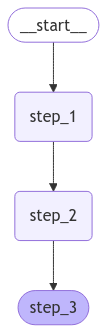

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

#### Usage

Let's proceed with a simple invocation:

In [6]:
graph.invoke({"value_1": "c"})

{'value_1': 'a b', 'value_2': 10}

Note that:

- We kicked off invocation by providing a value for a single state key. We must always provide a value for at least one key.
- The value we passed in was overwritten by the first node.
- The second node updated the value.
- The third node populated a different value.

### Built-in shorthand

!!! info "Prerequisites"
    `.add_sequence` requires `langgraph>=0.2.46`


LangGraph includes a built-in shorthand `.add_sequence` for convenience:

In [7]:
# highlight-next-line
builder = StateGraph(State).add_sequence([step_1, step_2, step_3])
builder.add_edge(START, "step_1")

graph = builder.compile()

graph.invoke({"value_1": "c"})

{'value_1': 'a b', 'value_2': 10}

## Create branches for parallel node execution

Parallel execution of nodes is essential to speed up overall graph operation. LangGraph offers native support for parallel execution of nodes, which can significantly enhance the performance of graph-based workflows. This parallelization is achieved through fan-out and fan-in mechanisms, utilizing both standard edges and [conditional_edges](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.MessageGraph.add_conditional_edges). Below are some examples showing how to add create branching dataflows that work for you. 

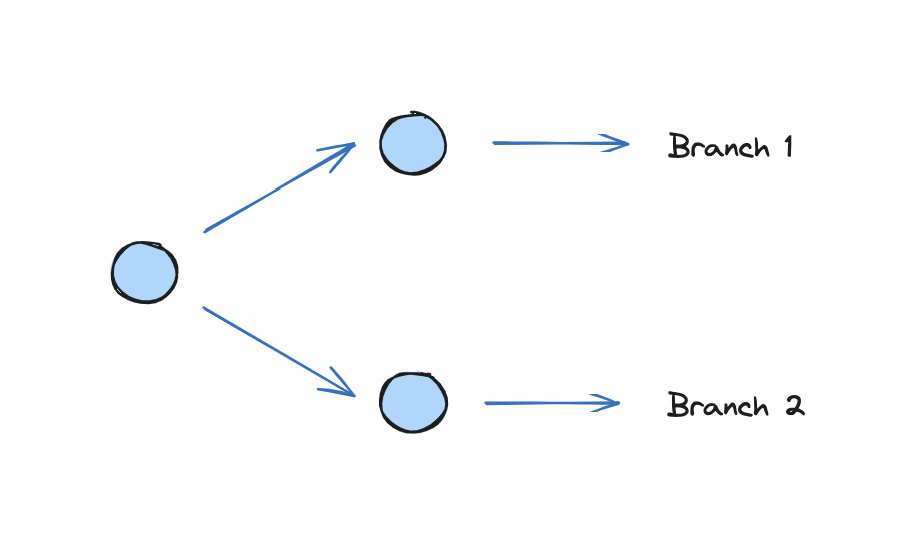

### How to run graph nodes in parallel

In this example, we fan out from `Node A` to `B and C` and then fan in to `D`. With our state, [we specify the reducer add operation](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers). This will combine or accumulate values for the specific key in the State, rather than simply overwriting the existing value. For lists, this means concatenating the new list with the existing list. See [this guide](../../how-tos/state-reducers) for more detail on updating state with reducers.

In [1]:
import operator
from typing import Annotated, Any

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]


def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}


builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

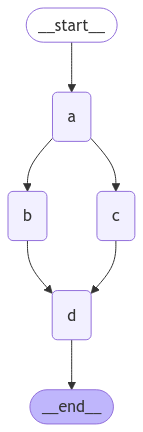

In [2]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

With the reducer, you can see that the values added in each node are accumulated.

In [8]:
graph.invoke({"aggregate": []}, {"configurable": {"thread_id": "foo"}})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "D" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'D']}

!!! note

    In the above example, nodes `"b"` and `"c"` are executed concurrently in the same [superstep](../../concepts/low_level/#graphs). Because they are in the same step, node `"d"` executes after both `"b"` and `"c"` are finished.

    Importantly, updates from a parallel superstep may not be ordered consistently. If you need a consistent, predetermined ordering of updates from a parallel superstep, you should write the outputs to a separate field in the state together with a value with which to order them.

<details class="note"> <summary>Exception handling?</summary>
 <p>LangGraph executes nodes within <a href="https://langchain-ai.github.io/langgraph/concepts/low_level/#graphs">"supersteps"</a>, meaning that while parallel branches are executed in parallel, the entire superstep is <b>transactional</b>. If any of these branches raises an exception, <b>none</b> of the updates are applied to the state (the entire superstep errors).</p>
<p>Importantly, when using a <a href="https://langchain-ai.github.io/langgraph/concepts/persistence/">checkpointer</a>, results from successful nodes within a superstep are saved, and don't repeat when resumed.</p>
 If you have error-prone (perhaps want to handle flakey API calls), LangGraph provides two ways to address this:<br>
 <ol>
  <li>You can write regular python code within your node to catch and handle exceptions.</li>
  <li>You can set a <b><a href="https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.graph.CompiledGraph.retry_policy">retry_policy</a></b> to direct the graph to retry nodes that raise certain types of exceptions. Only failing branches are retried, so you needn't worry about performing redundant work.</li>
</ol></p>
Together, these let you perform parallel execution and fully control exception handling.
</details>

### Parallel node fan-out and fan-in with extra steps

The above example showed how to fan-out and fan-in when each path was only one step. But what if one path had more than one step? Let's add a node `b_2` in the "b" branch:

In [4]:
def b_2(state: State):
    print(f'Adding "B_2" to {state["aggregate"]}')
    return {"aggregate": ["B_2"]}


builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(b_2)
builder.add_node(c)
builder.add_node(d)
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b_2")
# highlight-next-line
builder.add_edge(["b_2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

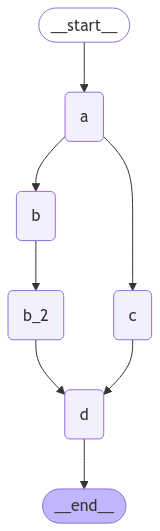

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
graph.invoke({"aggregate": []})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "B_2" to ['A', 'B', 'C']
Adding "D" to ['A', 'B', 'C', 'B_2']


{'aggregate': ['A', 'B', 'C', 'B_2', 'D']}

!!! note

    <p>In the above example, nodes `"b"` and `"c"` are executed concurrently in the same [superstep](../../concepts/low_level/#graphs). What happens in the next step?</p>
    <p>We use `add_edge(["b_2", "c"], "d")` here to force node `"d"` to only run when both nodes `"b_2"` and `"c"` have finished execution. If we added two separate edges,
    node `"d"` would run twice: after node `b2` finishes and once again after node `c` (in whichever order those nodes finish).</p>

### Conditional Branching

If your fan-out is not deterministic, you can use [add_conditional_edges](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph.add_conditional_edges) directly.

In [8]:
import operator
from typing import Annotated, Sequence

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    aggregate: Annotated[list, operator.add]
    # Add a key to the state. We will set this key to determine
    # how we branch.
    which: str


def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}


def e(state: State):
    print(f'Adding "E" to {state["aggregate"]}')
    return {"aggregate": ["E"]}


builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)
builder.add_node(e)
builder.add_edge(START, "a")


def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


intermediates = ["b", "c", "d"]
builder.add_conditional_edges(
    "a",
    route_bc_or_cd,
    intermediates,
)
for node in intermediates:
    builder.add_edge(node, "e")

builder.add_edge("e", END)
graph = builder.compile()

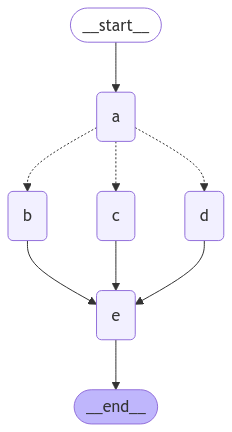

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
graph.invoke({"aggregate": [], "which": "bc"})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "E" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'E'], 'which': 'bc'}

In [11]:
graph.invoke({"aggregate": [], "which": "cd"})

Adding "A" to []
Adding "C" to ['A']
Adding "D" to ['A']
Adding "E" to ['A', 'C', 'D']


{'aggregate': ['A', 'C', 'D', 'E'], 'which': 'cd'}

## Create and control loops

When creating a graph with a loop, we require a mechanism for terminating execution. This is most commonly done by adding a [conditional edge](../../concepts/low_level/#conditional-edges) that routes to the [END](../../concepts/low_level/#end-node) node once we reach some termination condition.

You can also set the graph recursion limit when invoking or streaming the graph. The recursion limit sets the number of [supersteps](../../concepts/low_level/#graphs) that the graph is allowed to execute before it raises an error. Read more about the concept of recursion limits [here](../../concepts/low_level/#recursion-limit). 

Let's consider a simple graph with a loop to better understand how these mechanisms work.

!!! tip

    To return the last value of your state instead of receiving a recursion limit error, read [this how-to](../../how-tos/return-when-recursion-limit-hits/).


### Summary

When creating a loop, you can include a conditional edge that specifies a termination condition:
```python
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)

def route(state: State) -> Literal["b", END]:
    if termination_condition(state):
        return END
    else:
        return "a"

builder.add_edge(START, "a")
builder.add_conditional_edges("a", route)
builder.add_edge("b", "a")
graph = builder.compile()
```

To control the recursion limit, specify `"recursion_limit"` in the config. This will raise a `GraphRecursionError`, which you can catch and handle:
```python
from langgraph.errors import GraphRecursionError

try:
    graph.invoke(inputs, {"recursion_limit": 3})
except GraphRecursionError:
    print("Recursion Error")
```

### Define the graph

Let's define a graph with a simple loop. Note that we use a conditional edge to implement a termination condition.

In [1]:
import operator
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]


def a(state: State):
    print(f'Node A sees {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Node B sees {state["aggregate"]}')
    return {"aggregate": ["B"]}


# Define nodes
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)


# Define edges
def route(state: State) -> Literal["b", END]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END


builder.add_edge(START, "a")
builder.add_conditional_edges("a", route)
builder.add_edge("b", "a")
graph = builder.compile()

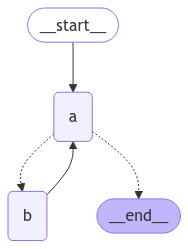

In [2]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

This architecture is similar to a [ReAct agent](../../how-tos/#prebuilt-react-agent) in which node `"a"` is a tool-calling model, and node `"b"` represents the tools.

In our `route` conditional edge, we specify that we should end after the `"aggregate"` list in the state passes a threshold length.

Invoking the graph, we see that we alternate between nodes `"a"` and `"b"` before terminating once we reach the termination condition.

In [3]:
graph.invoke({"aggregate": []})

Node A sees []
Node B sees ['A']
Node A sees ['A', 'B']
Node B sees ['A', 'B', 'A']
Node A sees ['A', 'B', 'A', 'B']
Node B sees ['A', 'B', 'A', 'B', 'A']
Node A sees ['A', 'B', 'A', 'B', 'A', 'B']


{'aggregate': ['A', 'B', 'A', 'B', 'A', 'B', 'A']}

### Impose a recursion limit

In some applications, we may not have a guarantee that we will reach a given termination condition. In these cases, we can set the graph's [recursion limit](../../concepts/low_level/#recursion-limit). This will raise a `GraphRecursionError` after a given number of [supersteps](../../concepts/low_level/#graphs). We can then catch and handle this exception:

In [4]:
from langgraph.errors import GraphRecursionError

try:
    graph.invoke({"aggregate": []}, {"recursion_limit": 4})
except GraphRecursionError:
    print("Recursion Error")

Node A sees []
Node B sees ['A']
Node A sees ['A', 'B']
Node B sees ['A', 'B', 'A']
Recursion Error


Note that this time we terminate after the fourth step.

### Loops with branches

To better understand how the recursion limit works, let's consider a more complex example. Below we implement a loop, but one step fans out into two nodes:

In [5]:
import operator
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    aggregate: Annotated[list, operator.add]


def a(state: State):
    print(f'Node A sees {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Node B sees {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Node C sees {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Node D sees {state["aggregate"]}')
    return {"aggregate": ["D"]}


# Define nodes
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)


# Define edges
def route(state: State) -> Literal["b", END]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END


builder.add_edge(START, "a")
builder.add_conditional_edges("a", route)
builder.add_edge("b", "c")
builder.add_edge("b", "d")
builder.add_edge(["c", "d"], "a")
graph = builder.compile()

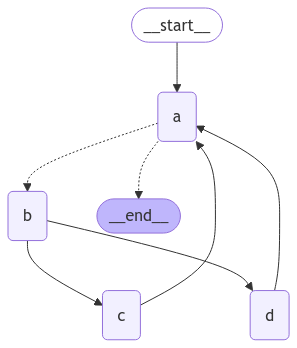

In [6]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

This graph looks complex, but can be conceptualized as loop of [supersteps](../../concepts/low_level/#graphs):

1. Node A
2. Node B
3. Nodes C and D
4. Node A
5. ...

We have a loop of four supersteps, where nodes C and D are executed concurrently.

Invoking the graph as before, we see that we complete two full "laps" before hitting the termination condition:

In [7]:
result = graph.invoke({"aggregate": []})

Node A sees []
Node B sees ['A']
Node D sees ['A', 'B']
Node C sees ['A', 'B']
Node A sees ['A', 'B', 'C', 'D']
Node B sees ['A', 'B', 'C', 'D', 'A']
Node D sees ['A', 'B', 'C', 'D', 'A', 'B']
Node C sees ['A', 'B', 'C', 'D', 'A', 'B']
Node A sees ['A', 'B', 'C', 'D', 'A', 'B', 'C', 'D']


However, if we set the recursion limit to four, we only complete one lap because each lap is four supersteps:

In [8]:
from langgraph.errors import GraphRecursionError

try:
    result = graph.invoke({"aggregate": []}, {"recursion_limit": 4})
except GraphRecursionError:
    print("Recursion Error")

Node A sees []
Node B sees ['A']
Node C sees ['A', 'B']
Node D sees ['A', 'B']
Node A sees ['A', 'B', 'C', 'D']
Recursion Error


## Visualize your graph

Here we demonstrate how to visualize the graphs you create.

### Set up Graph

You can visualize any arbitrary [Graph](https://langchain-ai.github.io/langgraph/reference/graphs/), including [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.state.StateGraph). Let's have some fun by drawing fractals :).

In [1]:
import random
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


class MyNode:
    def __init__(self, name: str):
        self.name = name

    def __call__(self, state: State):
        return {"messages": [("assistant", f"Called node {self.name}")]}


def route(state) -> Literal["entry_node", "__end__"]:
    if len(state["messages"]) > 10:
        return "__end__"
    return "entry_node"


def add_fractal_nodes(builder, current_node, level, max_level):
    if level > max_level:
        return

    # Number of nodes to create at this level
    num_nodes = random.randint(1, 3)  # Adjust randomness as needed
    for i in range(num_nodes):
        nm = ["A", "B", "C"][i]
        node_name = f"node_{current_node}_{nm}"
        builder.add_node(node_name, MyNode(node_name))
        builder.add_edge(current_node, node_name)

        # Recursively add more nodes
        r = random.random()
        if r > 0.2 and level + 1 < max_level:
            add_fractal_nodes(builder, node_name, level + 1, max_level)
        elif r > 0.05:
            builder.add_conditional_edges(node_name, route, node_name)
        else:
            # End
            builder.add_edge(node_name, "__end__")


def build_fractal_graph(max_level: int):
    builder = StateGraph(State)
    entry_point = "entry_node"
    builder.add_node(entry_point, MyNode(entry_point))
    builder.add_edge(START, entry_point)

    add_fractal_nodes(builder, entry_point, 1, max_level)

    # Optional: set a finish point if required
    builder.add_edge(entry_point, END)  # or any specific node

    return builder.compile()


app = build_fractal_graph(3)

### Mermaid

We can also convert a graph class into Mermaid syntax.

In [3]:
print(app.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	entry_node(entry_node)
	node_entry_node_A(node_entry_node_A)
	node_entry_node_B(node_entry_node_B)
	node_node_entry_node_B_A(node_node_entry_node_B_A)
	node_node_entry_node_B_B(node_node_entry_node_B_B)
	node_node_entry_node_B_C(node_node_entry_node_B_C)
	__end__([<p>__end__</p>]):::last
	__start__ --> entry_node;
	entry_node --> __end__;
	entry_node --> node_entry_node_A;
	entry_node --> node_entry_node_B;
	node_entry_node_B --> node_node_entry_node_B_A;
	node_entry_node_B --> node_node_entry_node_B_B;
	node_entry_node_B --> node_node_entry_node_B_C;
	node_entry_node_A -.-> entry_node;
	node_entry_node_A -.-> __end__;
	node_node_entry_node_B_A -.-> entry_node;
	node_node_entry_node_B_A -.-> __end__;
	node_node_entry_node_B_B -.-> entry_node;
	node_node_entry_node_B_B -.-> __end__;
	node_node_entry_node_B_C -.-> entry_node;
	node_node_entry_node_B_C -.-> __end__;
	classDef default fill:#f2f

### PNG

If preferred, we could render the Graph into a  `.png`. Here we could use three options:

- Using Mermaid.ink API (does not require additional packages)
- Using Mermaid + Pyppeteer (requires `pip install pyppeteer`)
- Using graphviz (which requires `pip install graphviz`)


#### Using Mermaid.Ink

By default, `draw_mermaid_png()` uses Mermaid.Ink's API to generate the diagram.

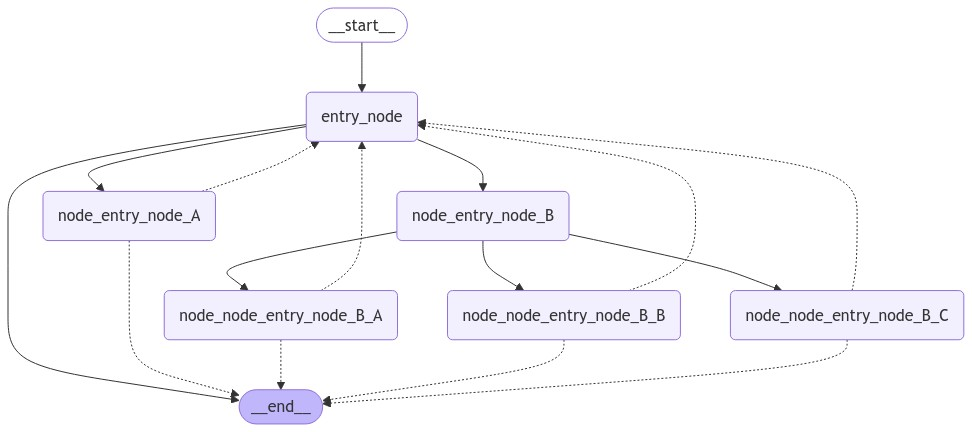

In [4]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

#### Using Mermaid + Pyppeteer

In [ ]:
%%capture --no-stderr
%pip install --quiet pyppeteer
%pip install --quiet nest_asyncio

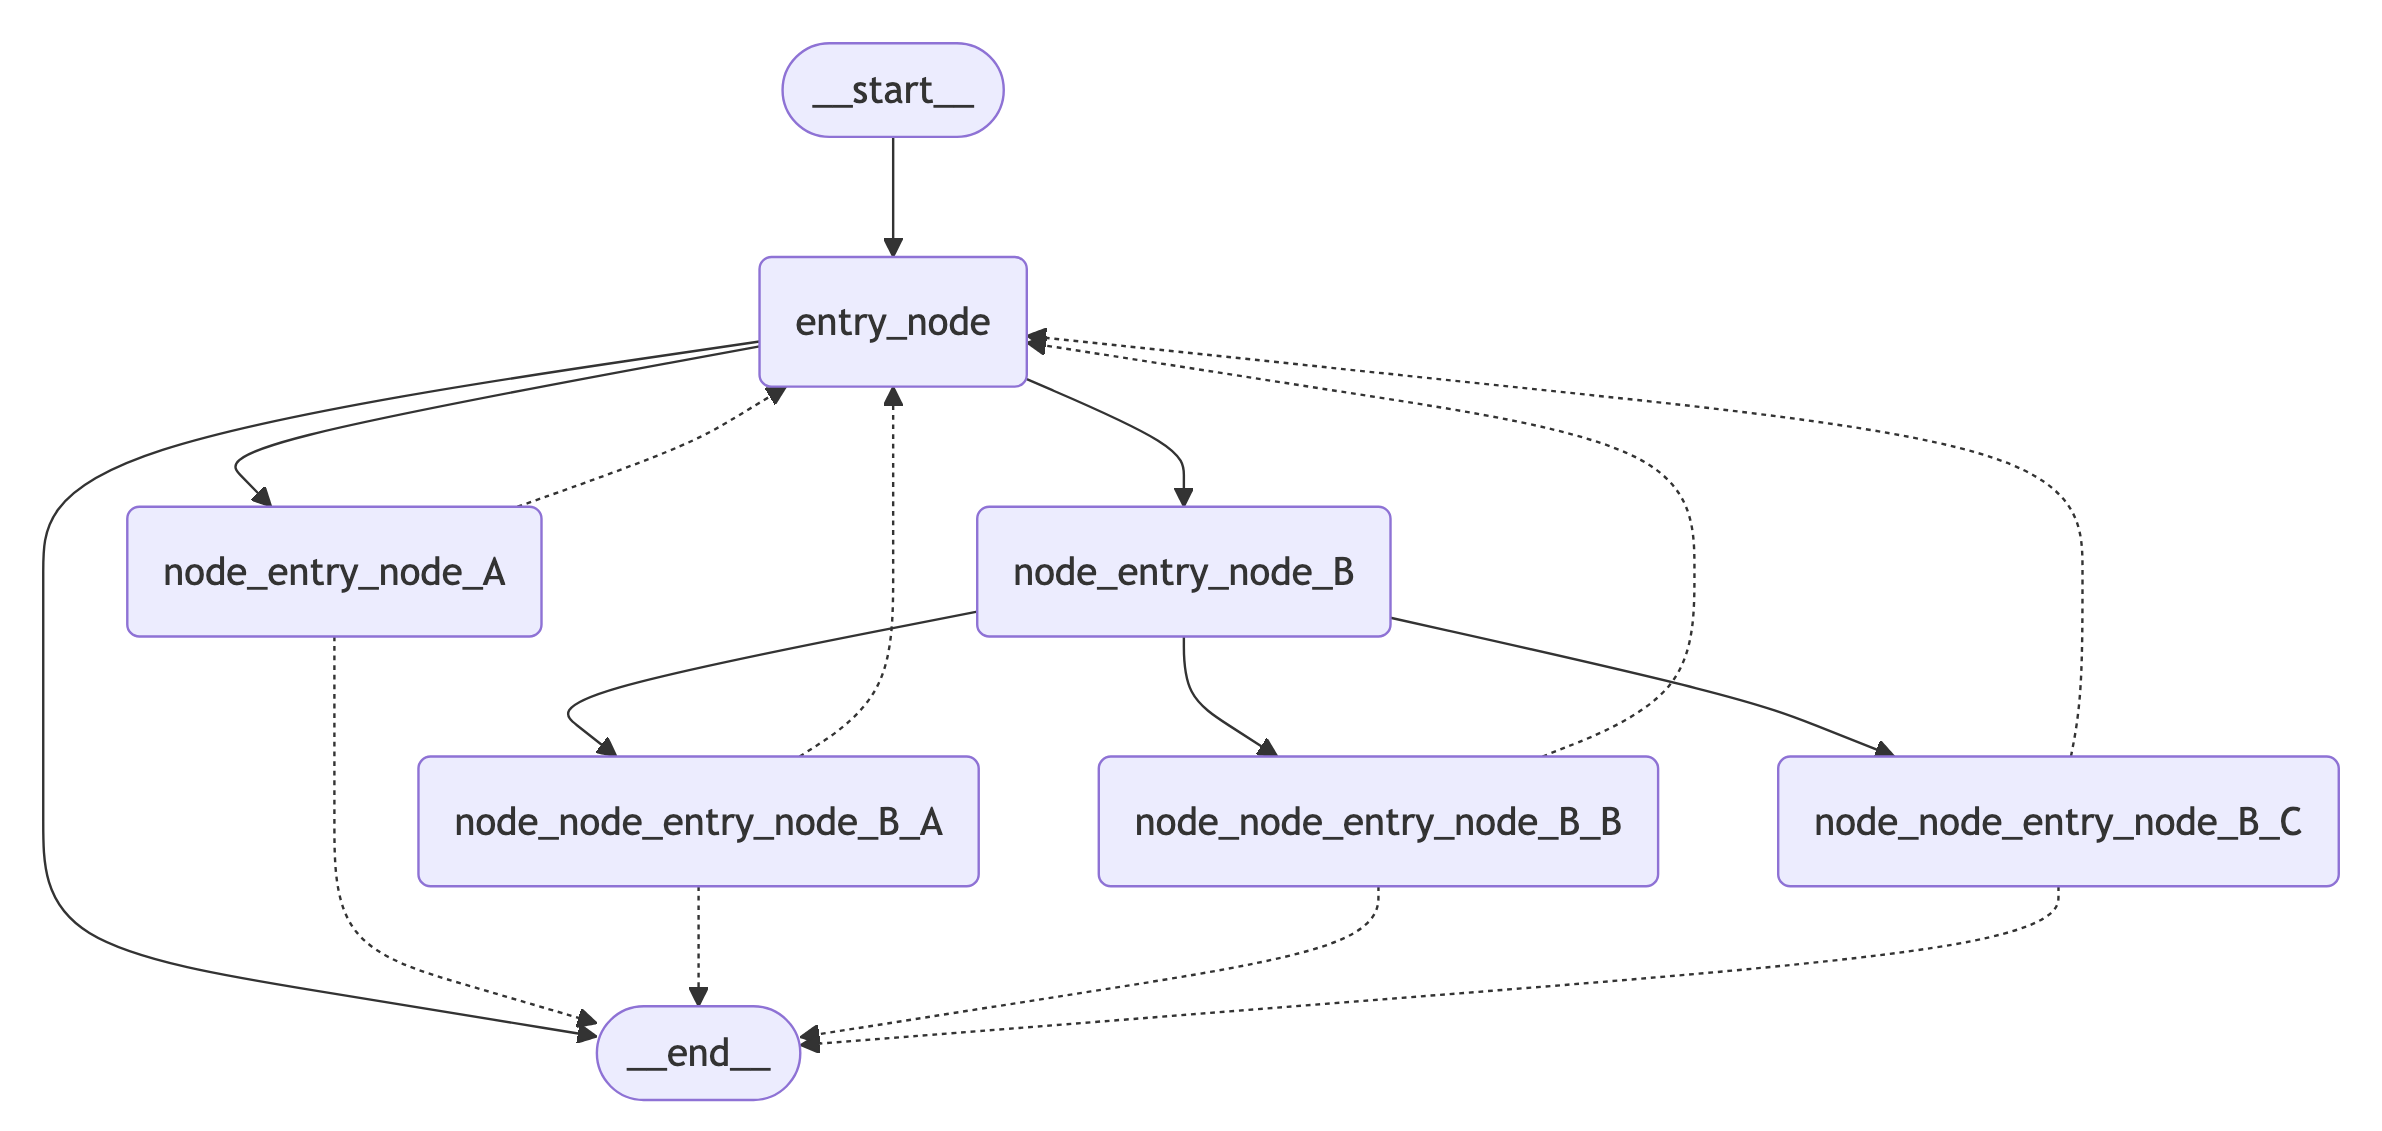

In [5]:
import nest_asyncio

nest_asyncio.apply()  # Required for Jupyter Notebook to run async functions

display(
    Image(
        app.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

#### Using Graphviz

In [ ]:
%%capture --no-stderr
%pip install pygraphviz

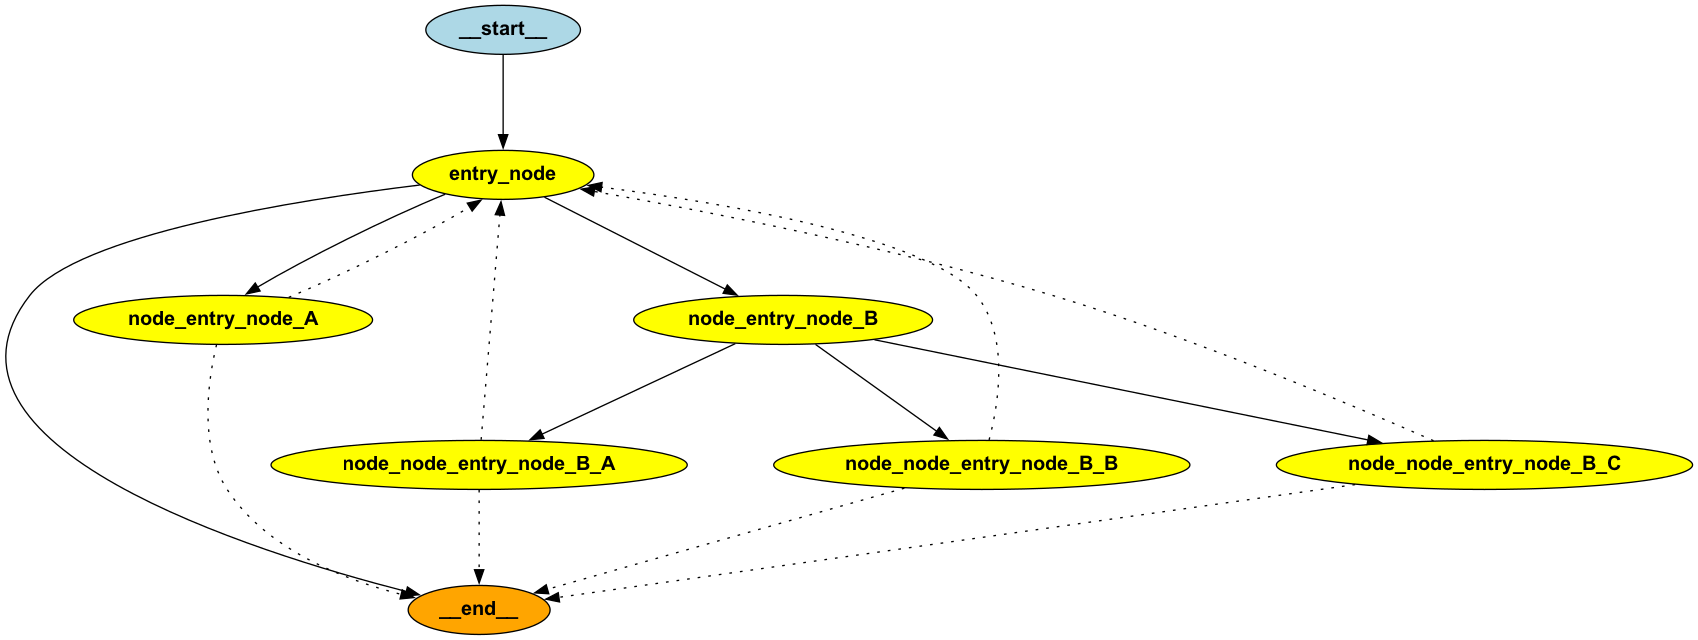

In [6]:
try:
    display(Image(app.get_graph().draw_png()))
except ImportError:
    print(
        "You likely need to install dependencies for pygraphviz, see more here https://github.com/pygraphviz/pygraphviz/blob/main/INSTALL.txt"
    )